In [1]:
import numpy as np
import pandas as pd
import pickle

from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras import activations
from keras import metrics
from keras import regularizers
import math

import random

# to make the experimens replicable
random.seed(123456)

Using TensorFlow backend.


## Important

as first step run the notebook `1. classification-dataset-creation.ipynb` to create the dataset.

In [2]:
dataset_path = '../data/dataset-dirigenti-split.pkl'

with open(dataset_path, 'rb') as f:
    train_samples, train_labels, val_samples, val_labels, test_samples, test_labels = pickle.load(f)

### Transform it in a dataset

In [3]:
train_samples[:5]

array([ 'RESIDUI PERENTI BILANCIO 1997 - IMPEGNO E LIQUIDAZIONE ALL ORDINE PROVINCIALE DEI MEDICI-CHIRURGHI E DEGLI ODONTOIATRI DI FIRENZE PERL ATTUAZIONE DI INIZIATIVE CULTURALI E SCIENTIFICHE DI SUPPORTO AI CORSI DI FORMAZIONE SPECIFICA IN MEDICINA GENERALE.',
       'L.R. 72/94 " Danni causati da animali predatori o da eventi meteorici al patrimonio zootecnico" - Liquidazione indennizzi beneficiari Euro 34.988,28=.',
       'Eventi alluvionali novembre 2000 - Interventi urgenti connessi alla difesa idraulica - Erogazione al Comune di Montemurlo (PO) saldo finanziamento spettante per realizzazione intervento n. 301 compreso nel Piano regionale di cui all`allegato 2 della DGRT n. 104/2003.',
       'APPROVAZIONE SCHEMA DI CONVENZIONE TRA LA REGIONE TOSCANA E I SOGGETTI PRIVATI AMMESSI A CONTRIBUTO PER I PROGETTI-INTERVENTO IN MATERIA DI PAESAGGIO',
       'Contributo al Comune di Siena per l`organizzazione della Terza giornata del Contemporaneo in programma nel mese di ottobre 2007.']

In [4]:
train_labels[:5]

array(['01943', '01934',
       'DIREZIONE GENERALE POLITICHE TERRITORIALI E AMBIENTALI',
       'DIREZIONE GENERALE POLITICHE TERRITORIALI E AMBIENTALI',
       'DIREZIONE GENERALE POLITICHE FORMATIVE, BENI E ATTIVIT'],
      dtype='<U54')

In [5]:
samples = np.concatenate([train_samples,val_samples, test_samples])
samples.shape

(138043,)

In [6]:
labels = np.concatenate([train_labels, val_labels, test_labels])
labels.shape

(138043,)

## Tokenize the Dataset

In [7]:
from keras.preprocessing.text import Tokenizer

In [8]:
num_words = 10000

In [9]:
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(samples)

In [10]:
freq_words = [(v,k) for k,v in tokenizer.word_docs.items()]

In [11]:
sorted(freq_words, key=lambda t: t[0], reverse=True)[:10]

[(108923, 'di'),
 (70047, 'e'),
 (62030, 'del'),
 (60358, 'per'),
 (48081, 'r'),
 (46824, 'l'),
 (44301, 'n'),
 (43630, 'a'),
 (40125, 'della'),
 (32549, 'in')]

In [12]:
train_sequences = tokenizer.texts_to_sequences(train_samples)
val_sequences = tokenizer.texts_to_sequences(val_samples)
test_sequences = tokenizer.texts_to_sequences(test_samples)

In [13]:
for s in train_sequences[:2]:
    print(s) 

[1120, 915, 418, 721, 14, 2, 18, 50, 2055, 530, 21, 1072, 2, 52, 1, 66, 179, 1, 691, 749, 2, 5399, 1, 512, 25, 723, 1, 129, 1100, 10, 558, 321]
[7, 6, 956, 88, 740, 2101, 45, 1187, 3733, 132, 45, 277, 4270, 13, 313, 1613, 18, 2539, 965, 221, 708, 7629, 298]


Convert labels to sequences

In [14]:
index_to_labels = dict(enumerate(set(labels)))
labels_to_index = {v:k for k,v in index_to_labels.items()}

In [15]:
len(index_to_labels)

20

In [16]:
print(labels_to_index)
print(len(labels_to_index))

{'01943': 0, '01934': 1, 'DIREZIONE ISTRUZIONE E FORMAZIONE': 2, 'DIREZIONE ORGANIZZAZIONE E SISTEMI INFORMATIVI': 3, 'DIREZIONE DIFESA DEL SUOLO E PROTEZIONE CIVILE': 4, 'DIREZIONE GENERALE POLITICHE FORMATIVE, BENI E ATTIVIT': 5, 'DIREZIONE GENERALE SVILUPPO ECONOMICO                 ': 6, 'POLITICHE AMBIENTALI, ENERGIA E CAMBIAMENTI CLIMATICI': 7, 'DIREZIONE AGRICOLTURA E SVILUPPO RURALE': 8, "D.G. COMPETITIVITA' DEL SISTEMA REGIONALE E SVILUPPO D": 9, 'DIREZIONE GENERALE POLITICHE TERRITORIALI E AMBIENTALI': 10, 'D.G. PRESIDENZA                                       ': 11, '01937': 12, 'DIREZIONE GENERALE DIRITTO ALLA SALUTE E POLITICHE DI ': 13, 'D.G.  AVVOCATURA                                      ': 14, '01025': 15, '01928': 16, '01946': 17, 'DIREZIONE DIRITTI DI CITTADINANZA E COESIONE SOCIALE': 18, 'DIREZIONE GENERALE BILANCIO E FINANZE                 ': 19}
20


In [17]:
encoded_train_labels = [labels_to_index[l] for l in train_labels]
encoded_val_labels = [labels_to_index[l] for l in val_labels]
encoded_test_labels = [labels_to_index[l] for l in test_labels]

In [18]:
encoded_train_labels[:10]

[0, 1, 10, 10, 5, 14, 3, 2, 19, 9]

### Preparing Data

- for the input data we pad the sequence to a max length in order to make uniform the sequences.
- for the labels we continue with one-hot encoding


In [19]:
from keras.preprocessing import sequence

In [20]:
print('max length of objects {}'.format(max(map(len, train_sequences))))

max length of objects 150


#### Maximum Sequence Length

for initial test we use the first 100 words

In [21]:
maxlen = 100

In [22]:
x_train_seq = sequence.pad_sequences(train_sequences, maxlen=maxlen)
x_val_seq = sequence.pad_sequences(val_sequences, maxlen=maxlen)
x_test_seq = sequence.pad_sequences(test_sequences, maxlen=maxlen)

In [23]:
x_train_seq.shape

(99390, 100)

One-hot encoding for input

In [24]:
def vectorize_sequences(sequences, dimension=10000):
    data = np.zeros((len(sequences), dimension), dtype=np.float32)
    for i, sequence in enumerate(sequences):
        data[i,sequence] = 1.
    return data

In [25]:
x_train = vectorize_sequences(train_sequences, num_words)
x_val = vectorize_sequences(val_sequences, num_words)
x_test = vectorize_sequences(test_sequences, num_words)

One hot encoding for the labels

In [26]:
def to_one_hot(labels):
    results = np.zeros((len(labels), len(set(labels))), dtype=np.float32)
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

In [27]:
y_train = to_one_hot(encoded_train_labels)
y_val = to_one_hot(encoded_val_labels)
y_test = to_one_hot(encoded_test_labels)

In [28]:
y_train

array([[ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)

## The Effects of Word Embeddings

Before using a word embedding as a layer in our network let evaluate the effect of embeddings by training a simple classifier that has it as only layer.

In [29]:
def build_model_only_embeddings(embed_size):
    model = models.Sequential()
    model.add(layers.Embedding(input_dim=num_words, output_dim=embed_size, input_length=maxlen, name='embed'))
    model.add(layers.Flatten())
    model.add(layers.Dense(len(labels_to_index), activation='softmax', name='softmax'))
    model.compile(optimizer=optimizers.Adam(), 
          loss='categorical_crossentropy',
          metrics=['accuracy'])
    return model

In [30]:
model_only_embed_small = build_model_only_embeddings(32)
model_only_embed_medium = build_model_only_embeddings(64)
model_only_embed_large = build_model_only_embeddings(128)

In [31]:
history_embed_small = model_only_embed_small.fit(x=x_train_seq, y=y_train, validation_data=(x_val_seq, y_val),
                   epochs=10, batch_size=256)

Train on 99390 samples, validate on 11044 samples
Epoch 1/10
99390/99390 [==============================] - 2s 25us/step - loss: 1.9546 - acc: 0.4358 - val_loss: 1.1618 - val_acc: 0.6563
Epoch 2/10
99390/99390 [==============================] - 1s 13us/step - loss: 0.9018 - acc: 0.7252 - val_loss: 0.7732 - val_acc: 0.7514
Epoch 3/10
99390/99390 [==============================] - 1s 13us/step - loss: 0.6294 - acc: 0.8053 - val_loss: 0.6448 - val_acc: 0.7879
Epoch 4/10
99390/99390 [==============================] - 1s 13us/step - loss: 0.4987 - acc: 0.8455 - val_loss: 0.5817 - val_acc: 0.8034
Epoch 5/10
99390/99390 [==============================] - 1s 13us/step - loss: 0.4149 - acc: 0.8729 - val_loss: 0.5473 - val_acc: 0.8129
Epoch 6/10
99390/99390 [==============================] - 1s 13us/step - loss: 0.3539 - acc: 0.8931 - val_loss: 0.5277 - val_acc: 0.8214
Epoch 7/10
99390/99390 [==============================] - 1s 12us/step - loss: 0.3057 - acc: 0.9100 - val_loss: 0.5152 - val_acc

In [32]:
history_embed_medium = model_only_embed_medium.fit(x=x_train_seq, y=y_train, validation_data=(x_val_seq, y_val),
                   epochs=10, batch_size=256)

Train on 99390 samples, validate on 11044 samples
Epoch 1/10
99390/99390 [==============================] - 2s 19us/step - loss: 1.7512 - acc: 0.4910 - val_loss: 0.9560 - val_acc: 0.7106
Epoch 2/10
99390/99390 [==============================] - 2s 20us/step - loss: 0.7359 - acc: 0.7724 - val_loss: 0.6581 - val_acc: 0.7862
Epoch 3/10
99390/99390 [==============================] - 2s 20us/step - loss: 0.5055 - acc: 0.8436 - val_loss: 0.5669 - val_acc: 0.8093
Epoch 4/10
99390/99390 [==============================] - 2s 20us/step - loss: 0.3879 - acc: 0.8819 - val_loss: 0.5230 - val_acc: 0.8232
Epoch 5/10
99390/99390 [==============================] - 2s 19us/step - loss: 0.3089 - acc: 0.9092 - val_loss: 0.5037 - val_acc: 0.8281
Epoch 6/10
99390/99390 [==============================] - 2s 20us/step - loss: 0.2494 - acc: 0.9309 - val_loss: 0.4967 - val_acc: 0.8315
Epoch 7/10
99390/99390 [==============================] - 2s 19us/step - loss: 0.2034 - acc: 0.9468 - val_loss: 0.4976 - val_acc

In [33]:
history_embed_large = model_only_embed_large.fit(x=x_train_seq, y=y_train, validation_data=(x_val_seq, y_val),
                   epochs=10, batch_size=256)

Train on 99390 samples, validate on 11044 samples
Epoch 1/10
99390/99390 [==============================] - 3s 28us/step - loss: 1.5247 - acc: 0.5522 - val_loss: 0.7951 - val_acc: 0.7509
Epoch 2/10
99390/99390 [==============================] - 3s 26us/step - loss: 0.6013 - acc: 0.8127 - val_loss: 0.5804 - val_acc: 0.8089
Epoch 3/10
99390/99390 [==============================] - 2s 24us/step - loss: 0.4011 - acc: 0.8775 - val_loss: 0.5196 - val_acc: 0.8224
Epoch 4/10
99390/99390 [==============================] - 2s 24us/step - loss: 0.2907 - acc: 0.9162 - val_loss: 0.4990 - val_acc: 0.8299
Epoch 5/10
99390/99390 [==============================] - 2s 24us/step - loss: 0.2160 - acc: 0.9415 - val_loss: 0.4920 - val_acc: 0.8315
Epoch 6/10
99390/99390 [==============================] - 2s 24us/step - loss: 0.1621 - acc: 0.9595 - val_loss: 0.4974 - val_acc: 0.8365
Epoch 7/10
99390/99390 [==============================] - 2s 24us/step - loss: 0.1237 - acc: 0.9709 - val_loss: 0.5110 - val_acc

In [34]:
import matplotlib.pyplot as plt

%matplotlib inline

In [35]:
def chart_loss(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, 'b+', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.yticks(np.arange(0,2.2, step=0.2))
    plt.xticks(epochs)
    plt.legend()
    plt.show()

In [36]:
def chart_acc(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'b+', label='Training Acc')
    plt.plot(epochs, val_acc, 'b', label='Validation Acc')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Accuray')
    plt.yticks(np.arange(0.4,1.05, step=0.05))
    plt.xticks(epochs)
    plt.legend()
    plt.show()

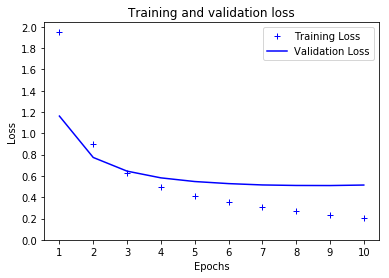

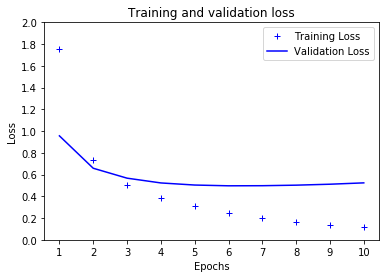

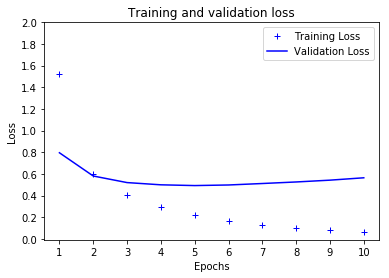

In [37]:
chart_loss(history_embed_small)
chart_loss(history_embed_medium)
chart_loss(history_embed_large)

We can see how the model with larger embedding size tend to overfit faster than the others (respectively epochs 2, 3, and 4). However, from a loss point of view all the models starts overfitting with a loss values ~ 0.8.
Let's now analyze values for accuracy.

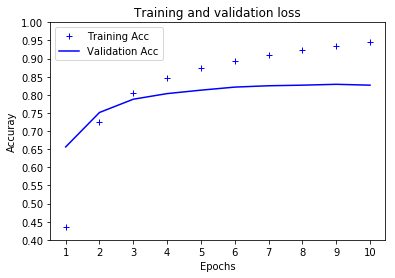

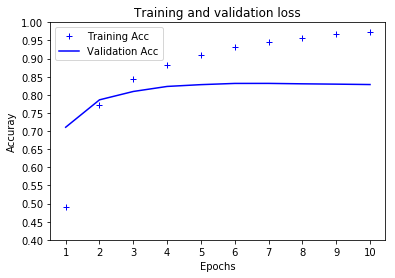

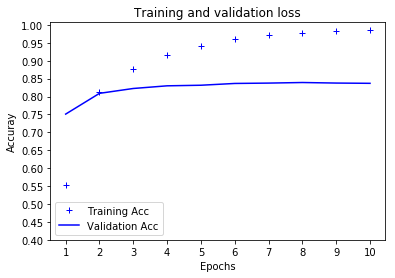

In [38]:
chart_acc(history_embed_small)
chart_acc(history_embed_medium)
chart_acc(history_embed_large)

In [39]:
def min_loss(history):
    val_loss = history.history['val_loss'] 
    return np.argmin(val_loss) + 1 

def accuracy(history, epoch):
    val_acc = history.history['val_acc']
    return val_acc[epoch - 1]

In [40]:
print('min loss for model small is {}'.format(min_loss(history_embed_small)))
print('min loss for model medium is {}'.format(min_loss(history_embed_medium)))
print('min loss for model large is {}'.format(min_loss(history_embed_large)))

min loss for model small is 9
min loss for model medium is 6
min loss for model large is 5


In [41]:
print('best validation accuracy for model small is {}'.format(
    accuracy(history_embed_small, min_loss(history_embed_small))))
print('best validation accuracy for model medium is {}'.format(
    accuracy(history_embed_medium, min_loss(history_embed_medium))))
print('best validation accuracy for model large is {}'.format(
    accuracy(history_embed_large, min_loss(history_embed_large))))

best validation accuracy for model small is 0.8290474466420913
best validation accuracy for model medium is 0.8314922129879047
best validation accuracy for model large is 0.8314922129447285


The results show how only using an flat classifier with an embedding layer we obtain an accuracy ~ 83%. Which is a pretty good result.
The next steps is use an embedding layers in a Feed Forward Neural Network.

## Build the Models

We take into account:
- a base model that uses dropout
- a embed model that adds an embedding layer

In [42]:
def build_model_dropout(neurons):
    model = models.Sequential()
    model.add(layers.Dense(neurons, activation='relu', input_shape=(x_train.shape[-1], )))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(neurons, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(neurons, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(len(labels_to_index), activation='softmax'))
    
    model.compile(optimizer=optimizers.Adam(), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model

In [43]:
def build_model_embeddings(neurons, embed_size):
    model = models.Sequential()
    model.add(layers.Embedding(input_dim=num_words, output_dim=embed_size, input_length=maxlen))
    model.add(layers.Flatten())
    model.add(layers.Dense(neurons, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(neurons, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(len(labels_to_index), activation='softmax'))
    model.compile(optimizer=optimizers.Adam(), 
          loss='categorical_crossentropy',
          metrics=['accuracy'])
    return model

In [44]:
model_dropout = build_model_dropout(256)

In [60]:
model_dropout.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               2560256   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 20)                5140      
Total para

In [45]:
history_dropout = model_dropout.fit(x=x_train, y=y_train, validation_data=(x_val, y_val),
                   epochs=10, batch_size=256)

Train on 99390 samples, validate on 11044 samples
Epoch 1/10
99390/99390 [==============================] - 5s 48us/step - loss: 1.2842 - acc: 0.5953 - val_loss: 0.5836 - val_acc: 0.8035
Epoch 2/10
99390/99390 [==============================] - 4s 42us/step - loss: 0.6286 - acc: 0.7916 - val_loss: 0.4793 - val_acc: 0.8380
Epoch 3/10
99390/99390 [==============================] - 4s 43us/step - loss: 0.4805 - acc: 0.8378 - val_loss: 0.4513 - val_acc: 0.8425
Epoch 4/10
99390/99390 [==============================] - 4s 42us/step - loss: 0.4012 - acc: 0.8643 - val_loss: 0.4364 - val_acc: 0.8492
Epoch 5/10
99390/99390 [==============================] - 4s 42us/step - loss: 0.3457 - acc: 0.8820 - val_loss: 0.4407 - val_acc: 0.8539
Epoch 6/10
99390/99390 [==============================] - 4s 42us/step - loss: 0.3078 - acc: 0.8955 - val_loss: 0.4458 - val_acc: 0.8550
Epoch 7/10
99390/99390 [==============================] - 4s 43us/step - loss: 0.2758 - acc: 0.9065 - val_loss: 0.4442 - val_acc

In [46]:
model_embed = build_model_embeddings(128,64)

In [47]:
history_embed = model_embed.fit(x=x_train_seq, y=y_train, validation_data=(x_val_seq, y_val),
                   epochs=10, batch_size=256)

Train on 99390 samples, validate on 11044 samples
Epoch 1/10
99390/99390 [==============================] - 3s 31us/step - loss: 1.8941 - acc: 0.4042 - val_loss: 0.8206 - val_acc: 0.7392
Epoch 2/10
99390/99390 [==============================] - 3s 27us/step - loss: 0.7987 - acc: 0.7431 - val_loss: 0.6196 - val_acc: 0.7916
Epoch 3/10
99390/99390 [==============================] - 3s 28us/step - loss: 0.5573 - acc: 0.8191 - val_loss: 0.5850 - val_acc: 0.8073
Epoch 4/10
99390/99390 [==============================] - 3s 26us/step - loss: 0.4240 - acc: 0.8609 - val_loss: 0.6186 - val_acc: 0.8086
Epoch 5/10
99390/99390 [==============================] - 3s 27us/step - loss: 0.3350 - acc: 0.8904 - val_loss: 0.6411 - val_acc: 0.8090
Epoch 6/10
99390/99390 [==============================] - 3s 26us/step - loss: 0.2705 - acc: 0.9128 - val_loss: 0.6871 - val_acc: 0.8097
Epoch 7/10
99390/99390 [==============================] - 3s 26us/step - loss: 0.2243 - acc: 0.9271 - val_loss: 0.7579 - val_acc

### Printing The Loss

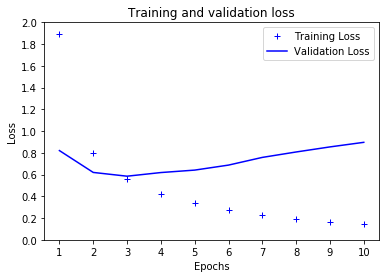

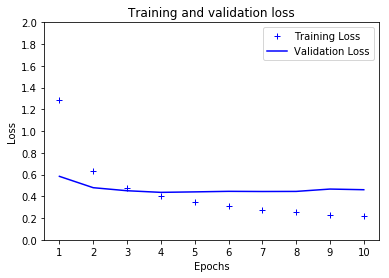

In [48]:
chart_loss(history_embed)
chart_loss(history_dropout)

From the charts we can see that: 
- word embedding seems to not improve the accuracy of the model. This is usual in the case you have little training data available. From another point of view it is surprising to see that the classifier with only an embedding layer perform better than the one taken into account here
- the model with dropout perform better than the model with embeddings.

From this result one could gather that embeddings are not useful. This is wrong, because we didn't consider that we changed another thing with the current represantion. The model that uses embedding takes as input sequence of ids and not a vectorize representation of subjects. 

In the next post we will explore the usage of LSTM to address this kind of representation. 

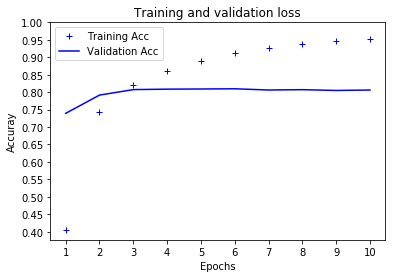

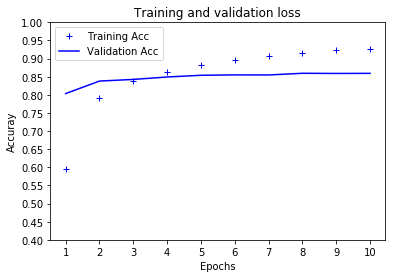

In [49]:
chart_acc(history_embed)
chart_acc(history_dropout)

From the chart above we can see that the best model is the model that uses dropout, while the best epoch is the 6 where the validation accuracy crosses the training accuracy

In [50]:
def compare_loss(histories):
    epochs = range(1, len(list(histories.values())[0].history['val_loss']) + 1)

    for i, history in histories.items():
        val_loss = history.history['val_loss']
        plt.plot(epochs, val_loss, label='Validation Loss {}'.format(i))
            
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

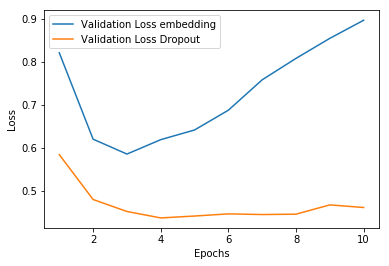

In [51]:
compare_loss({'embedding': history_embed, 'Dropout': history_dropout})

Another interesting factor is that the loss of the model that uses embeddings grows during the training. It shows that embedding trained with the model aren't useful.
Another approach can be uses:
- pretrained embeddings
- remove some of the most frequent words

In [52]:
def compare_accuracy(histories):
    epochs = range(1, len(list(histories.values())[0].history['val_acc']) + 1)

    for i, history in histories.items():
        val_loss = history.history['val_acc']
        plt.plot(epochs, val_loss, label='Validation Accuracy {}'.format(i))
            
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

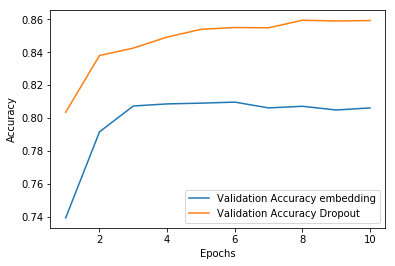

In [53]:
compare_accuracy({'embedding': history_embed, 'Dropout': history_dropout})

In [54]:
print('min loss for model Embed {}'.format(min_loss(history_embed)))
print('min loss for model Dropout is {}'.format(min_loss(history_dropout)))

min loss for model Embed 3
min loss for model Dropout is 4


In [55]:
print('best validation accuracy for model Embed {}'.format(
    accuracy(history_embed, min_loss(history_embed))))
print('best validation accuracy for model Dropout {}'.format(
    accuracy(history_dropout, min_loss(history_dropout))))

best validation accuracy for model Embed 0.8073161898510735
best validation accuracy for model Dropout 0.8492394060339025


### Evaluate on the Test Set

We still want to evaluate the models with embedding to understand if it overfits on input data.

In [56]:
model = build_model_embeddings(128,64)

In [57]:
history = model.fit(x=np.concatenate([x_train_seq, x_val_seq]), y=np.concatenate([y_train, y_val]), epochs=4, batch_size=256)

Epoch 1/4
110434/110434 [==============================] - 3s 29us/step - loss: 1.8434 - acc: 0.4159
Epoch 2/4
110434/110434 [==============================] - 3s 25us/step - loss: 0.7742 - acc: 0.7491
Epoch 3/4
110434/110434 [==============================] - 3s 25us/step - loss: 0.5494 - acc: 0.8206
Epoch 4/4
110434/110434 [==============================] - 3s 25us/step - loss: 0.4186 - acc: 0.8624


In [58]:
loss, acc = model.evaluate(x_test_seq, y_test)

27609/27609 [==============================] - 1s 31us/step


In [59]:
print('loss {}'.format(loss))
print('acc {}'.format(acc))

loss 0.5977673401498903
acc 0.8120902604136905


## Conclusion

We evaluated how to use Embeddings as alternative to one-hot encoding. 
